In [1]:
# Step 4 and Step 5

from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout,UpSampling2D
from tensorflow.keras.applications.xception import  Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import warnings
warnings.filterwarnings("ignore")
import tensorflow.keras as keras
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.layers import concatenate,Dense,Flatten,Dropout,Average
import operator
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate,Dense,Flatten,Dropout
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
import tensorflow.keras.callbacks as kcallbacks
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

In [2]:
#generate training and test images

TARGET_SIZE=(224,224)     
INPUT_SIZE=(224,224,3)    
BATCHSIZE=32	

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        './train_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        './test_224/',
        target_size=TARGET_SIZE,
        batch_size=BATCHSIZE,
        class_mode='categorical')

Found 1048 images belonging to 5 classes.
Found 261 images belonging to 5 classes.


In [3]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [4]:
history_this= LossHistory()

In [5]:
def xception( num_class, epochs,savepath='./xception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:121]:		
        layer.trainable = False
    for layer in model_fine_tune.layers[121:]:
        layer.trainable = True

    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='xception')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    #train model
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        # class_weight=class_weights,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8779
Epoch 00001: val_accuracy improved from -inf to 0.58621, saving model to .\xception.h5
33/33 [==============================] - 40s 1s/step - loss: 0.3842 - accuracy: 0.8779 - val_loss: 15.3120 - val_accuracy: 0.5862
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9714
Epoch 00002: val_accuracy did not improve from 0.58621
33/33 [==============================] - 38s 1s/step - loss: 0.1149 - accuracy: 0.9714 - val_loss: 22.9243 - val_accuracy: 0.5287
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9847
Epoch 00003: val_accuracy improved from 0.58621 to 0.93103, saving model to .\xception.h5
33/33 [==============================] - 37s 1s/step - loss: 0.0532 - accuracy: 0.9847 - val_loss: 0.4936 - val_accuracy: 0.9310
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9847
Epo

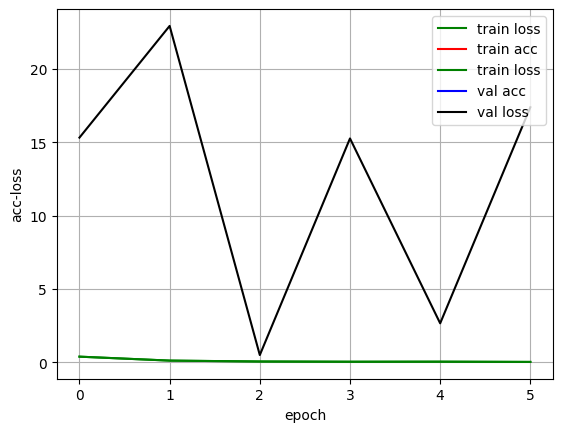

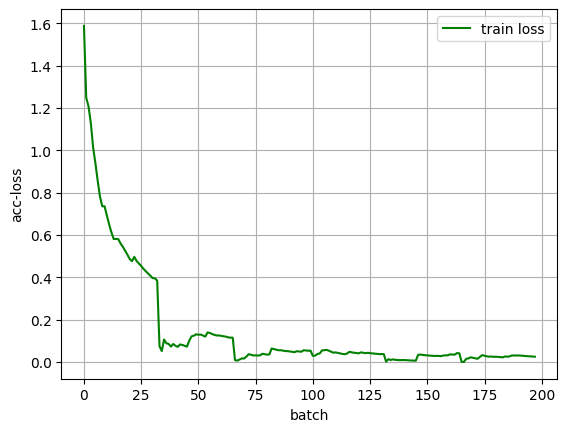

In [6]:
xception(num_class=5,epochs=20) 
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [7]:
def vgg16( num_class, epochs,savepath='./VGG16.h5',history=history_this,input_shape=INPUT_SIZE):
    
    model_fine_tune = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    for layer in model_fine_tune.layers[:15]:
        layer.trainable = False
    for layer in model_fine_tune.layers[15:]:
        layer.trainable = True
        
    
    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	
    
    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 3.1664 - accuracy: 0.3330
Epoch 00001: val_accuracy improved from -inf to 0.45594, saving model to .\VGG16.h5
33/33 [==============================] - 64s 2s/step - loss: 3.1664 - accuracy: 0.3330 - val_loss: 1.3474 - val_accuracy: 0.4559
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 1.1401 - accuracy: 0.4704
Epoch 00002: val_accuracy improved from 0.45594 to 0.72797, saving model to .\VGG16.h5
33/33 [==============================] - 69s 2s/step - loss: 1.1401 - accuracy: 0.4704 - val_loss: 0.7508 - val_accuracy: 0.7280
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.7204
Epoch 00003: val_accuracy improved from 0.72797 to 0.90421, saving model to .\VGG16.h5
33/33 [==============================] - 67s 2s/step - loss: 0.5941 - accuracy: 0.7204 - val_loss: 0.3603 - val_accuracy: 0.90

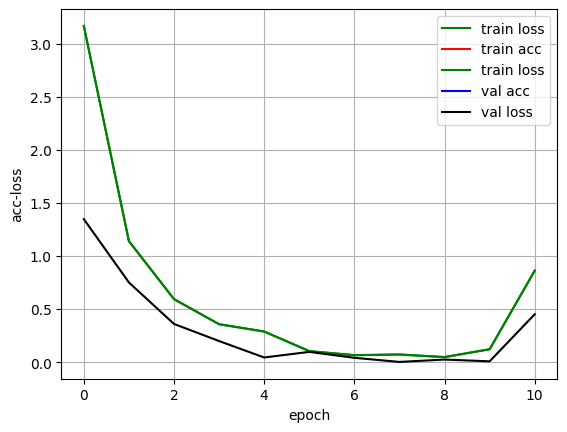

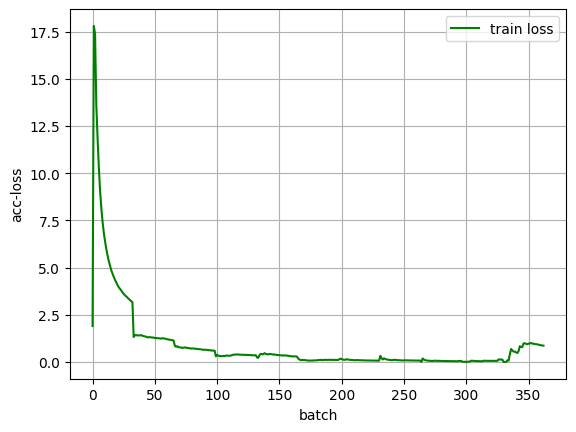

In [8]:

vgg16(num_class=5,epochs=20)
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [5]:
def vgg19( num_class, epochs,savepath='./VGG19.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:19]:	
        layer.trainable = False
    for layer in model_fine_tune.layers[19:]:
        layer.trainable = True
        

    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='vgg')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])	

    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        #workers=2,
        callbacks=[earlyStopping, saveBestModel, history],
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 1.5047 - accuracy: 0.6031
Epoch 00001: val_accuracy improved from -inf to 0.82375, saving model to .\VGG19.h5
33/33 [==============================] - 83s 3s/step - loss: 1.5047 - accuracy: 0.6031 - val_loss: 0.5937 - val_accuracy: 0.8238
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.8807
Epoch 00002: val_accuracy improved from 0.82375 to 0.92720, saving model to .\VGG19.h5
33/33 [==============================] - 80s 2s/step - loss: 0.2901 - accuracy: 0.8807 - val_loss: 0.1655 - val_accuracy: 0.9272
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9342
Epoch 00003: val_accuracy improved from 0.92720 to 0.99617, saving model to .\VGG19.h5
33/33 [==============================] - 84s 3s/step - loss: 0.1900 - accuracy: 0.9342 - val_loss: 0.0449 - val_accuracy: 0.99

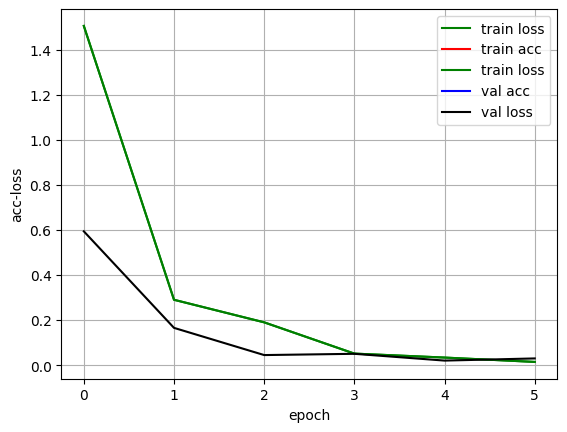

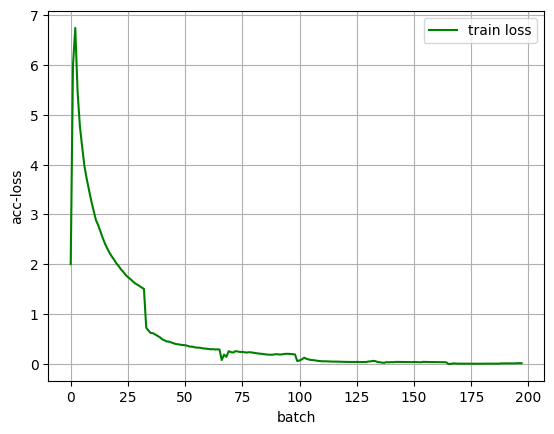

In [6]:

vgg19(num_class=5,epochs=20)	
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [8]:
def inception( num_class, epochs,savepath='./inception.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:148]:	
        layer.trainable = False
    for layer in model_fine_tune.layers[148:]:	
        layer.trainable = True
        

    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.8282
Epoch 00001: val_accuracy improved from -inf to 0.45594, saving model to .\inception.h5
33/33 [==============================] - 45s 1s/step - loss: 0.6747 - accuracy: 0.8282 - val_loss: 13913.5322 - val_accuracy: 0.4559
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9313
Epoch 00002: val_accuracy improved from 0.45594 to 0.71648, saving model to .\inception.h5
33/33 [==============================] - 47s 1s/step - loss: 0.2600 - accuracy: 0.9313 - val_loss: 1340.3029 - val_accuracy: 0.7165
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9790
Epoch 00003: val_accuracy did not improve from 0.71648
33/33 [==============================] - 48s 1s/step - loss: 0.0972 - accuracy: 0.9790 - val_loss: 981.0156 - val_accuracy: 0.6437
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0

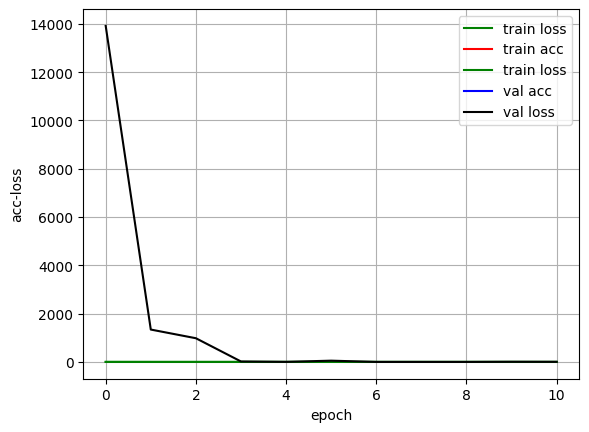

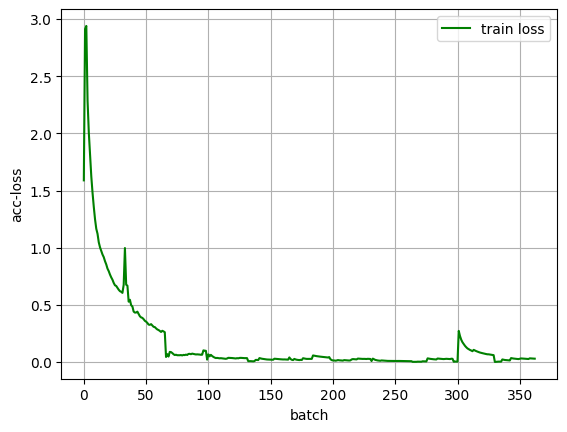

In [9]:
inception(num_class=5,epochs=20)	
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [10]:
def inceptionresnet( num_class, epochs,savepath='./inceptionresnet.h5',history=history_this,input_shape=INPUT_SIZE):
    model_fine_tune = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in model_fine_tune.layers[:522]:	
        layer.trainable = False
    for layer in model_fine_tune.layers[522:]:	
        layer.trainable = True
        

    
    model = GlobalAveragePooling2D()(model_fine_tune.output)
    
    model=Dense(units=256,activation='relu')(model)
    model=Dropout(0.5)(model)
    model = Dense(num_class, activation='softmax')(model)
    model = Model(model_fine_tune.input, model, name='resnet')
    opt = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08)	
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

    earlyStopping = kcallbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, verbose=1, mode='auto')	#set early stop patience to save training time
    saveBestModel = kcallbacks.ModelCheckpoint(
        filepath=savepath,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='auto')
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        #use_multiprocessing=True, 
        callbacks=[earlyStopping, saveBestModel, history],
    )

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.8140 - accuracy: 0.7567
Epoch 00001: val_accuracy improved from -inf to 0.11111, saving model to .\inceptionresnet.h5
33/33 [==============================] - 172s 5s/step - loss: 0.8140 - accuracy: 0.7567 - val_loss: 5239305216.0000 - val_accuracy: 0.1111
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9265
Epoch 00002: val_accuracy improved from 0.11111 to 0.27586, saving model to .\inceptionresnet.h5
33/33 [==============================] - 160s 5s/step - loss: 0.2030 - accuracy: 0.9265 - val_loss: 33528.0234 - val_accuracy: 0.2759
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.2910 - accuracy: 0.9179
Epoch 00003: val_accuracy did not improve from 0.27586
33/33 [==============================] - 177s 5s/step - loss: 0.2910 - accuracy: 0.9179 - val_loss: 3285.2483 - val_accuracy: 0.1418
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss

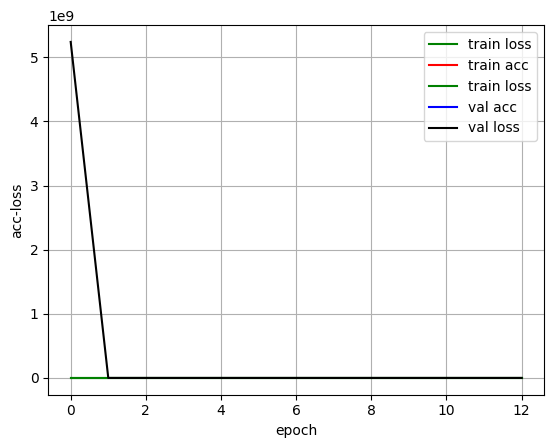

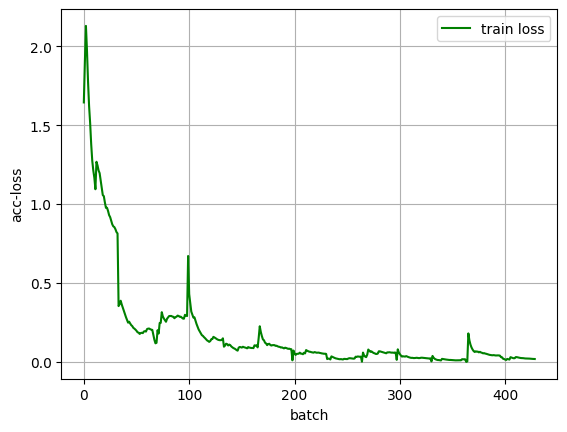

In [11]:
inceptionresnet(num_class=5,epochs=20)	# 5-class classificaiton
history_this.loss_plot('epoch')
history_this.loss_plot('batch')
plt.show()

In [13]:
#generate images from train set and validation set
TARGET_SIZE=(224,224)     # was (20,20)
INPUT_SIZE=(224,224,3)    # was (20,20,3)
BATCHSIZE=32           # could try 128 or 32

test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
            './test_224/',
            target_size=TARGET_SIZE,
            batch_size=BATCHSIZE,
            class_mode='categorical')

Found 261 images belonging to 5 classes.


In [14]:
#generate labels indicating class
label=validation_generator.class_indices
label={v: k for k, v in label.items()}

In [15]:
print(label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [16]:
#read images from validation folder

rootdir = './test_224/'


test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\10247.png


In [17]:
 #load model 1: xception
xception_model=load_model('./xception.h5')

In [18]:
 #load model 2: VGG16
vgg_model=load_model('./VGG16.h5')

In [19]:
 #load model 3: VGG19
vgg19_model=load_model('./VGG19.h5')

In [20]:
 #load model 4: inception
incep_model=load_model('./inception.h5')

In [21]:
 #load model 5: inceptionresnet
inres_model=load_model('./inceptionresnet.h5')

In [29]:
for i,layer in enumerate(xception_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [30]:
for i,layer in enumerate(vgg_model.layers):
    print(i,layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d_1
20 dense_2
21 dropout_1
22 dense_3


In [31]:
for i,layer in enumerate(vgg19_model.layers):
    print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d
23 dense
24 dropout
25 dense_1


In [32]:
for i,layer in enumerate(incep_model.layers):
    print(i,layer.name)

0 input_2
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [33]:
for i,layer in enumerate(inres_model.layers):
    print(i,layer.name)

0 input_3
1 conv2d_94
2 batch_normalization_94
3 activation_94
4 conv2d_95
5 batch_normalization_95
6 activation_95
7 conv2d_96
8 batch_normalization_96
9 activation_96
10 max_pooling2d_4
11 conv2d_97
12 batch_normalization_97
13 activation_97
14 conv2d_98
15 batch_normalization_98
16 activation_98
17 max_pooling2d_5
18 conv2d_102
19 batch_normalization_102
20 activation_102
21 conv2d_100
22 conv2d_103
23 batch_normalization_100
24 batch_normalization_103
25 activation_100
26 activation_103
27 average_pooling2d_9
28 conv2d_99
29 conv2d_101
30 conv2d_104
31 conv2d_105
32 batch_normalization_99
33 batch_normalization_101
34 batch_normalization_104
35 batch_normalization_105
36 activation_99
37 activation_101
38 activation_104
39 activation_105
40 mixed_5b
41 conv2d_109
42 batch_normalization_109
43 activation_109
44 conv2d_107
45 conv2d_110
46 batch_normalization_107
47 batch_normalization_110
48 activation_107
49 activation_110
50 conv2d_106
51 conv2d_108
52 conv2d_111
53 batch_normaliz

In [35]:
model1=Model(inputs=[xception_model.layers[0].get_input_at(0)],outputs=xception_model.get_layer('dense_1').output,name='xception')
model2=Model(inputs=[vgg_model.layers[0].get_input_at(0)],outputs=vgg_model.get_layer('dense_3').output,name='vgg')
model3=Model(inputs=[vgg19_model.layers[0].get_input_at(0)],outputs=vgg19_model.get_layer('dense_1').output,name='vgg19')
model4=Model(inputs=[incep_model.layers[0].get_input_at(0)],outputs=incep_model.get_layer('dense_3').output,name='incep')
model5=Model(inputs=[inres_model.layers[0].get_input_at(0)],outputs=inres_model.get_layer('dense_5').output,name='inres')

In [36]:
#plot the figures
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [37]:
ensemble_history= LossHistory()

In [38]:
#generate training and test images
TARGET_SIZE=(224,224)     # was (20,20)
INPUT_SIZE=(224,224,3)    # was (20,20,3)

BATCHSIZE=32	#could try 128 or 32

#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

upsampled_data = False

if upsampled_data:
    train_generator = train_datagen.flow_from_directory(
            './upsampled_train/',
            target_size=TARGET_SIZE,
            batch_size=BATCHSIZE,
            class_mode='categorical')
    validation_generator = test_datagen.flow_from_directory(
            './upsampled_test/',
            target_size=TARGET_SIZE,
            batch_size=BATCHSIZE,
            class_mode='categorical')
else:
    train_generator = train_datagen.flow_from_directory(
            './train_224/',
            target_size=TARGET_SIZE,
            batch_size=BATCHSIZE,
            class_mode='categorical')
    validation_generator = test_datagen.flow_from_directory(
            './test_224/',
            target_size=TARGET_SIZE,
            batch_size=BATCHSIZE,
            class_mode='categorical')

Found 1048 images belonging to 5 classes.
Found 261 images belonging to 5 classes.


In [39]:
def lr_decay(epoch):
    lrs = [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0001,0.00001,0.000001,
           0.000001,0.000001,0.000001,0.000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001,0.0000001
          ]
    return lrs[epoch]

In [40]:
auto_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
my_lr = LearningRateScheduler(lr_decay)

In [41]:
def ensemble(num_class,epochs,savepath='./ensemble.h5'):
    img=Input(shape=(224,224,3),name='img')
    feature1=model1(img)
    feature2=model2(img)
    feature3=model3(img)
    x=concatenate([feature1,feature2,feature3])
    x=Dropout(0.5)(x)
    x=Dense(64,activation='relu')(x)
    x=Dropout(0.25)(x)
    output=Dense(num_class,activation='softmax',name='output')(x)
    model=Model(inputs=img,outputs=output)
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    #train model
    earlyStopping=kcallbacks.EarlyStopping(monitor='val_accuracy',patience=2, verbose=1, mode='auto')
    saveBestModel = kcallbacks.ModelCheckpoint(filepath=savepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    hist=model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[earlyStopping,saveBestModel,ensemble_history,auto_lr],
    )

In [42]:
ensemble_model=ensemble(num_class=5,epochs=20)

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 1.3331 - accuracy: 0.4924
Epoch 00001: val_accuracy improved from -inf to 0.80077, saving model to .\ensemble.h5
33/33 [==============================] - 207s 6s/step - loss: 1.3331 - accuracy: 0.4924 - val_loss: 1.0271 - val_accuracy: 0.8008
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.9860 - accuracy: 0.6517
Epoch 00002: val_accuracy improved from 0.80077 to 0.88889, saving model to .\ensemble.h5
33/33 [==============================] - 155s 5s/step - loss: 0.9860 - accuracy: 0.6517 - val_loss: 0.7013 - val_accuracy: 0.8889
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.7834
Epoch 00003: val_accuracy improved from 0.88889 to 0.99617, saving model to .\ensemble.h5
33/33 [==============================] - 154s 5s/step - loss: 0.7457 - accuracy: 0.7834 - val_loss: 0.4956 - val_accuracy: 0.9962
Epoch 4/20
33/33 [==============================] - ETA: 0s -

In [43]:
ensemble_model=load_model('./ensemble.h5')

In [44]:
#read images from validation folder

if upsampled_data:
    rootdir = './upsampled_test/'
else:
    rootdir = './test_224/'

test_laels = []
test_images=[]
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not (file.endswith(".jpeg"))|(file.endswith(".jpg"))|(file.endswith(".png")):
            continue
        test_laels.append(subdir.split('/')[-1])
        test_images.append(os.path.join(subdir, file))
        
print(test_laels[0],test_images[0])

0 ./test_224/0\10247.png


In [45]:
#test the averaging model on the validation set

predict=[]
length=len(test_images)
t1 = time.time()
for i in range((length//127)+1):
    inputimg=test_images[127*i:127*(i+1)]
    test_batch=[]
    for path in inputimg:
        thisimg=np.array(Image.open(path))/255
        test_batch.append(thisimg)
    #print(i, np.array(test_batch).shape)
    ensemble_model_batch=ensemble_model.predict(np.array(test_batch))
    predict_batch=list(np.argmax(ensemble_model_batch,axis=1))
    predict_batch=[label[con] for con in predict_batch]
    predict.append(predict_batch)

predict=sum(predict,[])

t2 = time.time()
print('The testing time is :%f seconds' % (t2-t1))

The testing time is :30.557205 seconds


In [46]:

acc=accuracy_score(test_laels,predict)
print('Concatenation accuracy:%s'%acc)

Concatenation accuracy:1.0


In [47]:
acc=accuracy_score(test_laels,predict)
pre=precision_score(test_laels,predict,average='weighted')
re=recall_score(test_laels,predict,average='weighted')
f1=f1_score(test_laels,predict,average='weighted')
print('ensemble accuracy: %s'%acc)
print('precision: %s'%pre)
print('recall: %s'%re)
print('f1: %s'%f1)

print(confusion_matrix(test_laels, predict))
target_names = ['0', '1','2','3','4']
print(classification_report(test_laels, predict, target_names=target_names))

ensemble accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
[[119   0   0   0   0]
 [  0  29   0   0   0]
 [  0   0  72   0   0]
 [  0   0   0  29   0]
 [  0   0   0   0  12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        72
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        12

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



In [48]:
label_map = {0: 'Benign', 1: 'DDoS', 2: 'DoS Hulk', 3: 'FTP-Patator', 4: 'SSH-Patator'}

In [49]:
y_true_list = [int(i) for i in test_laels]
y_pred_list = [int(i) for i in predict]

In [50]:
y_true_mapped = [label_map[y] for y in y_true_list]
y_pred_mapped = [label_map[y] for y in y_pred_list]


print(classification_report(y_true_mapped, y_pred_mapped, zero_division=1))
print('\n')
print('                    Confusion Matrix')

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       119
        DDoS       1.00      1.00      1.00        29
    DoS Hulk       1.00      1.00      1.00        72
 FTP-Patator       1.00      1.00      1.00        29
 SSH-Patator       1.00      1.00      1.00        12

    accuracy                           1.00       261
   macro avg       1.00      1.00      1.00       261
weighted avg       1.00      1.00      1.00       261



                    Confusion Matrix


In [51]:

y_true_mapped = [label_map[y] for y in y_true_list]
y_pred_mapped = [label_map[y] for y in y_pred_list]

report = classification_report(y_true_mapped, y_pred_mapped, zero_division=1, output_dict=True)

cm = confusion_matrix(y_true_mapped, y_pred_mapped)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

for label, metrics in report.items():
    if isinstance(metrics, dict):  # skip accuracy, macro avg, etc.
        print(f"\nClass: {label}")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.3f}")



for class_label, acc in zip(report.keys(), per_class_accuracy):
    if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {class_label} Accuracy: {acc * 100:.3f}%")
        
        
        


Class: Benign
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 119.000

Class: DDoS
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 29.000

Class: DoS Hulk
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 72.000

Class: FTP-Patator
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 29.000

Class: SSH-Patator
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 12.000

Class: macro avg
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 261.000

Class: weighted avg
  precision: 1.000
  recall: 1.000
  f1-score: 1.000
  support: 261.000
Class Benign Accuracy: 100.000%
Class DDoS Accuracy: 100.000%
Class DoS Hulk Accuracy: 100.000%
Class FTP-Patator Accuracy: 100.000%
Class SSH-Patator Accuracy: 100.000%
